In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

In [6]:
crop=pd.read_csv(r"crop_yield.csv")
crop

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909
...,...,...,...,...,...,...,...,...,...,...
19684,Small millets,1998,Kharif,Nagaland,4000.0,2000,1498.0,395200.00,1160.00,0.500000
19685,Wheat,1998,Rabi,Nagaland,1000.0,3000,1498.0,98800.00,290.00,3.000000
19686,Maize,1997,Kharif,Jammu and Kashmir,310883.0,440900,1356.2,29586735.11,96373.73,1.285000
19687,Rice,1997,Kharif,Jammu and Kashmir,275746.0,5488,1356.2,26242746.82,85481.26,0.016667


In [7]:
# Basic info
crop.info()

# Summary statistics
crop.describe()

# Check missing values
crop.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             19689 non-null  object 
 1   Crop_Year        19689 non-null  int64  
 2   Season           19689 non-null  object 
 3   State            19689 non-null  object 
 4   Area             19689 non-null  float64
 5   Production       19689 non-null  int64  
 6   Annual_Rainfall  19689 non-null  float64
 7   Fertilizer       19689 non-null  float64
 8   Pesticide        19689 non-null  float64
 9   Yield            19689 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.5+ MB


Crop               0
Crop_Year          0
Season             0
State              0
Area               0
Production         0
Annual_Rainfall    0
Fertilizer         0
Pesticide          0
Yield              0
dtype: int64

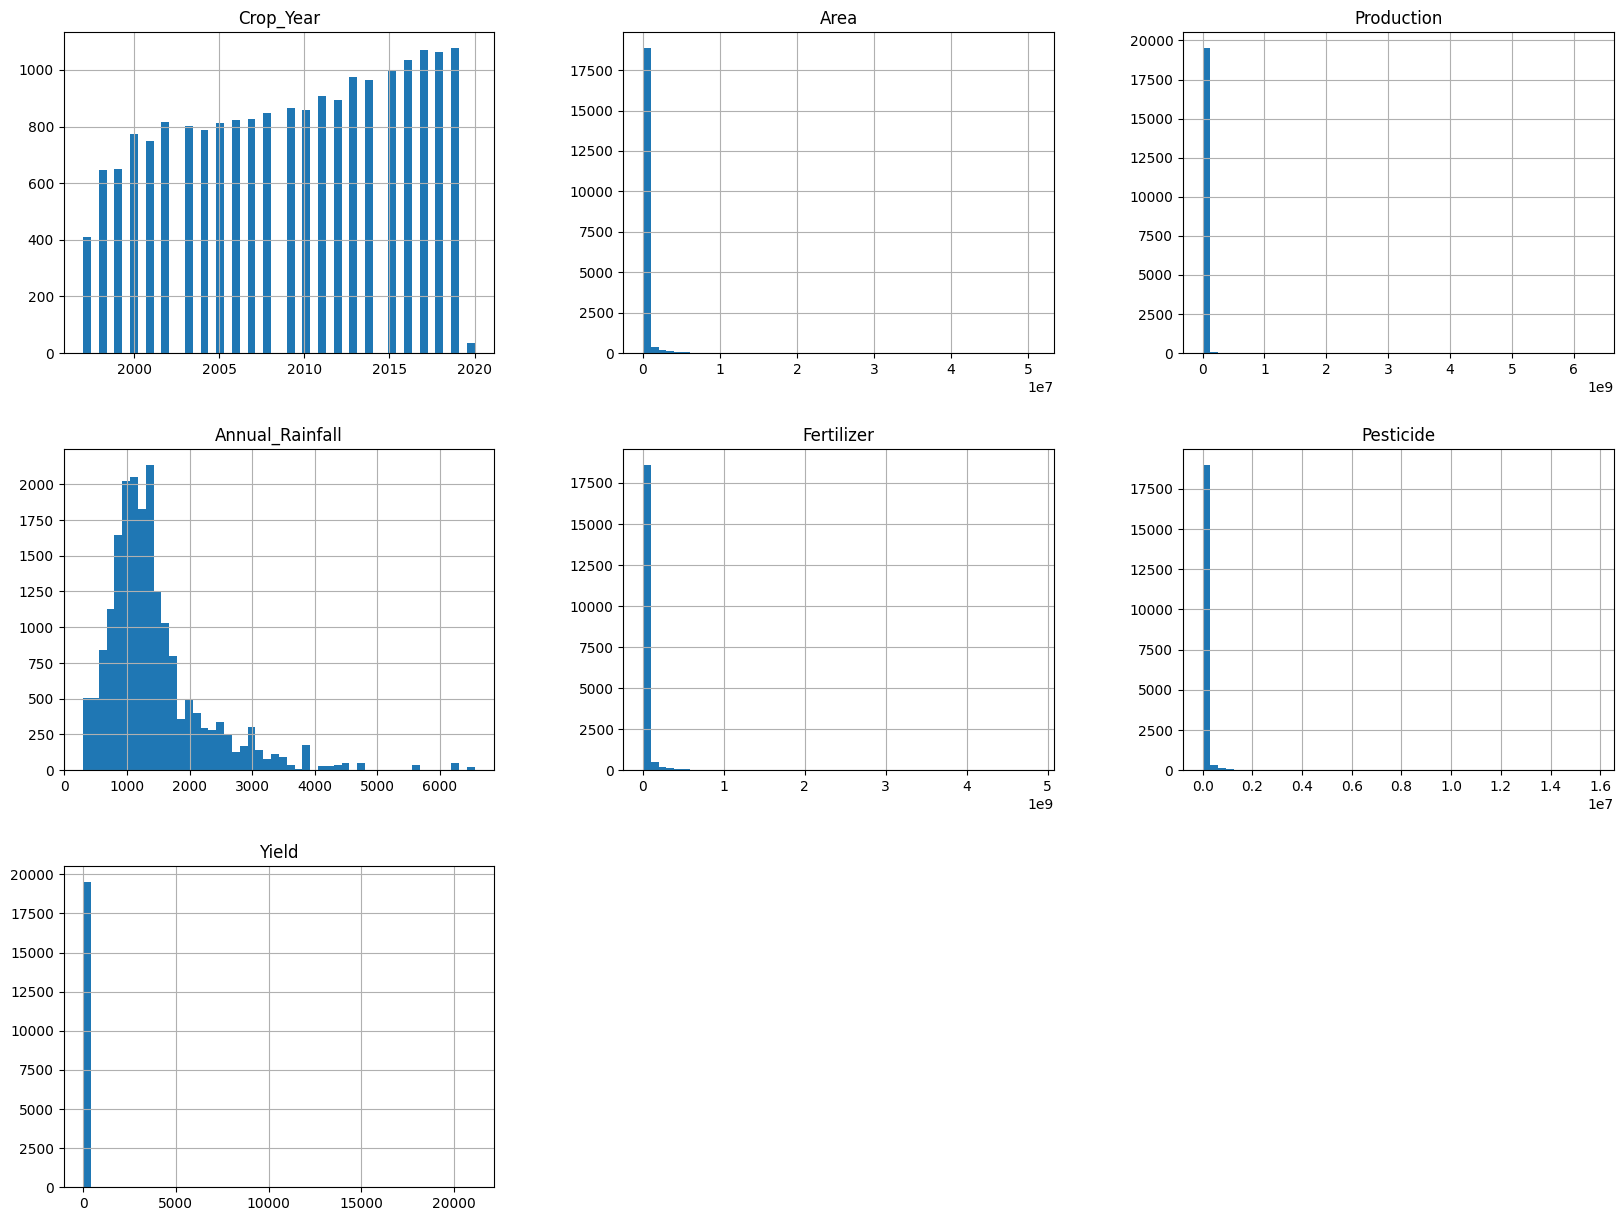

In [8]:
import matplotlib.pyplot as plt

# Histograms of numeric features
crop.hist(bins=50, figsize=(20,15))
plt.show()


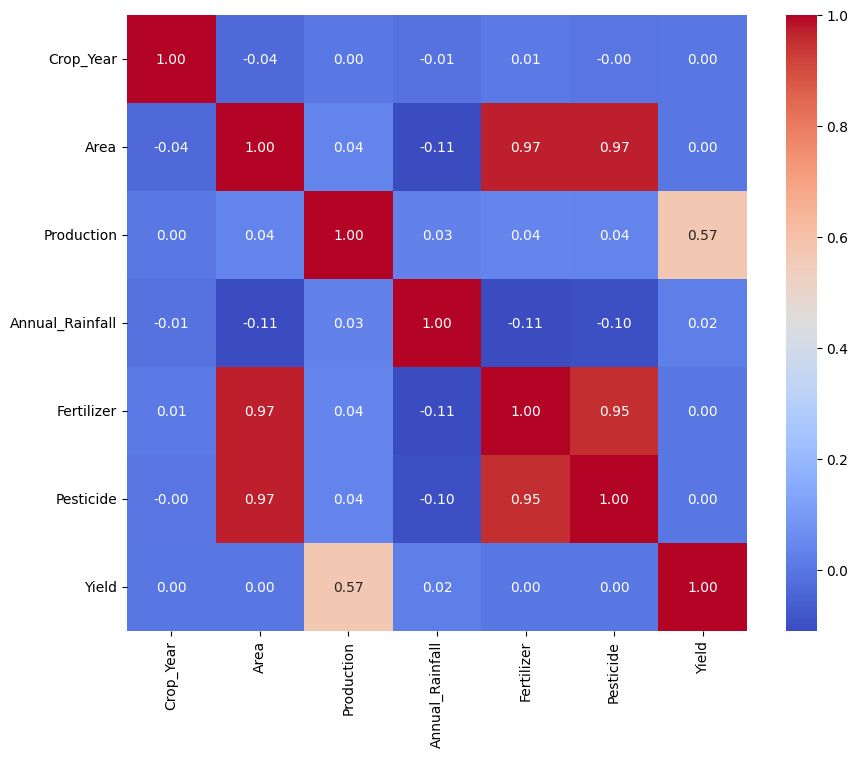

Yield              1.000000
Production         0.570809
Annual_Rainfall    0.020761
Fertilizer         0.002862
Crop_Year          0.002539
Area               0.001858
Pesticide          0.001782
Name: Yield, dtype: float64


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Keep only numeric columns for correlation
corr_matrix = crop.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

# Correlation of Yield with other numeric features
print(corr_matrix["Yield"].sort_values(ascending=False))


In [10]:
# Create new ratio features
crop["yield_per_area"] = crop["Production"] / crop["Area"]
crop["fertilizer_per_area"] = crop["Fertilizer"] / crop["Area"]
crop["pesticide_per_area"] = crop["Pesticide"] / crop["Area"]


In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(crop, test_size=0.2, random_state=42)

print(train_set.shape, test_set.shape)


(15751, 13) (3938, 13)


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Separate features & target
X = train_set.drop("Yield", axis=1)
y = train_set["Yield"].copy()

# Numerical & categorical columns
num_attribs = ["Crop_Year", "Area", "Production", "Annual_Rainfall", "Fertilizer", "Pesticide",
               "yield_per_area", "fertilizer_per_area", "pesticide_per_area"]

cat_attribs = ["Crop", "Season", "State"]

# Numerical pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Full pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
])

# Transform training data
X_prepared = full_pipeline.fit_transform(X)


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# 7. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_prepared, y)
y_pred_lin = lin_reg.predict(X_prepared)
lin_rmse = np.sqrt(mean_squared_error(y, y_pred_lin))

# 8. Decision Tree
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_prepared, y)
y_pred_tree = tree_reg.predict(X_prepared)
tree_rmse = np.sqrt(mean_squared_error(y, y_pred_tree))

# 9. Random Forest (with verbose & faster training)
forest_reg = RandomForestRegressor(
    n_estimators=30,        # fewer trees for speed
    max_depth=15,           # limit depth for faster training
    random_state=42,
    n_jobs=-1,              # use all CPU cores
    verbose=1               # 👈 shows training progress
)
forest_reg.fit(X_prepared, y)
y_pred_forest = forest_reg.predict(X_prepared)
forest_rmse = np.sqrt(mean_squared_error(y, y_pred_forest))

# Results
print("\n--- Training Results ---")
print("Linear Regression RMSE:", lin_rmse)
print("Decision Tree RMSE:", tree_rmse)
print("Random Forest RMSE:", forest_rmse)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.



--- Training Results ---
Linear Regression RMSE: 73.28640665115738
Decision Tree RMSE: 7.440795798779715e-18
Random Forest RMSE: 28.764294502453296


[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  22 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    0.0s finished


In [14]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(forest_reg, X_prepared, y,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print("Scores:", rmse_scores)
print("Mean:", rmse_scores.mean())
print("Std Dev:", rmse_scores.std())


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  22 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  22 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 co

Scores: [196.36559733  41.48307011  82.03243452  45.96153971  81.37961916
  63.78183851  76.72007812  52.22989259  76.81250689 104.26809924]
Mean: 82.10346761770471
Std Dev: 42.176981349393564


[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  22 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    0.0s finished


In [15]:
# Prepare test set
X_test = test_set.drop("Yield", axis=1)
y_test = test_set["Yield"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = forest_reg.predict(X_test_prepared)

final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print("Final RMSE on Test Set:", final_rmse)


Final RMSE on Test Set: 63.83600581889846


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  22 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    0.0s finished
